# Linear Support Vector Machine (SVM) Classifier Exploration

In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn mne -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import mne
from scipy.interpolate import griddata
import seaborn as sns

## Imagined Movements dataset

In [3]:
df_imag_class_1 = pd.read_csv('../data/feaSubEImg_1.csv', header=None)
df_imag_class_2 = pd.read_csv('../data/feaSubEImg_2.csv', header=None)

In [4]:
df1_im = df_imag_class_1.T
df2_im = df_imag_class_2.T

In [5]:
X = pd.concat([df1_im, df2_im], axis=0)
y = np.array([0]*df1_im.shape[0] + [1]*df2_im.shape[0])

In [6]:
X.shape

(240, 204)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Linear SVM Classifier Training

In [8]:
# Train linear SVM
clf = SVC(kernel='linear', C=1., probability=True) # C is the regularization parameter
clf.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [9]:
y_pred = clf.predict(X_test)
y_score = clf.decision_function(X_test)  # this is your decision statistic
accuracy = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_score)

In [10]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8611111111111112
Accuracy: 0.8611
ROC AUC: 0.9327

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.76      0.84        34
           1       0.82      0.95      0.88        38

    accuracy                           0.86        72
   macro avg       0.87      0.86      0.86        72
weighted avg       0.87      0.86      0.86        72



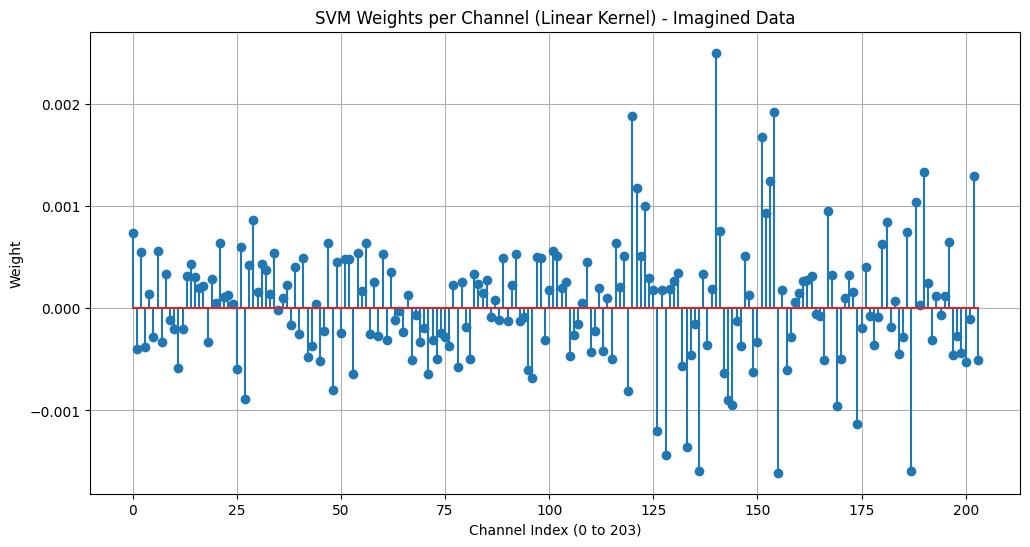

In [11]:
weights = clf.coef_.flatten()  # shape: (204,)
plt.figure(figsize=(12, 6))
plt.stem(weights)
plt.title("SVM Weights per Channel (Linear Kernel) - Imagined Data")
plt.xlabel("Channel Index (0 to 203)")
plt.ylabel("Weight")
plt.grid(True)
plt.savefig("../figures/linearSVM/linearSVM_weights_perChannel_imagined.png")
plt.show()

In [12]:
electrode_coords = pd.read_csv("../data/BCIsensor_xy.csv", header=None).values
electrode_coords_scaled = electrode_coords / np.max(np.abs(electrode_coords))  # Normalize to [-1, 1]

In [13]:
# 204 = 102 electrodes × 2 channels (Ex, Ey)
W = clf.coef_.flatten()
W_x = W[::2]  # x-gradient
W_y = W[1::2]  # y-gradient

# Combine into a single scalar per electrode
W_mag = np.sqrt(W_x**2 + W_y**2)  # shape: (102,)

In [14]:
electrode_names = [f"e{i}" for i in range(1, 103)]  # fake names for 102 electrodes
sfreq = 100  # arbitrary sampling rate (no information given)
info = mne.create_info(ch_names=electrode_names, sfreq=sfreq, ch_types='eeg')

In [15]:
electrode_coords_3d = np.hstack([electrode_coords_scaled, np.zeros((electrode_coords.shape[0], 1))])
pos_dict = dict(zip(electrode_names, electrode_coords_3d))
montage = mne.channels.make_dig_montage(ch_pos=pos_dict, coord_frame='head')
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: e1, e2, e3, e4, e5, e6, e7, e8, e9, e10, e11, e12, e13, e14, ...
 chs: 102 EEG
 custom_ref_applied: False
 dig: 105 items (3 Cardinal, 102 EEG)
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 102
 projs: []
 sfreq: 100.0 Hz
>

### Linear SVM result visualization

#### Weight spatial view

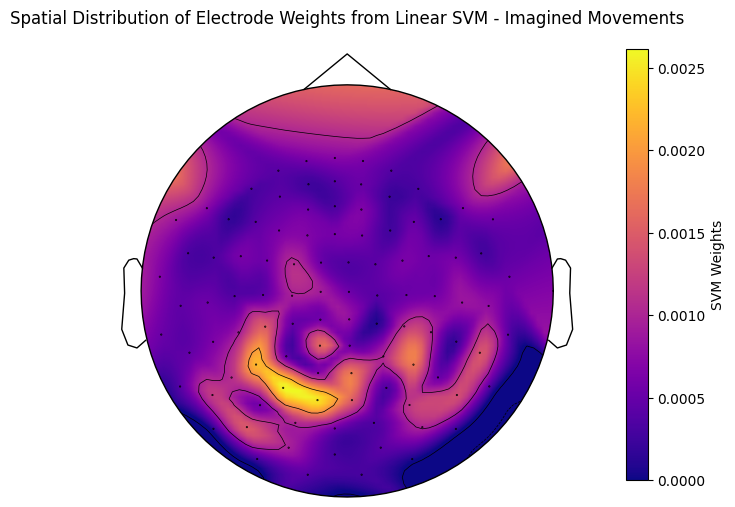

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title("Spatial Distribution of Electrode Weights from Linear SVM - Imagined Movements")

# Plot the topomap with a colorbar
im, _ = mne.viz.plot_topomap(
    W_mag,
    electrode_coords_scaled,
    axes=ax,
    show=False,  # Disable immediate display to add the colorbar
    cmap='plasma',
    names=None,
    outlines='head',  # Include head outline
    sphere=(0, 0, 0, 1.1),  # Define the sphere for the head
    extrapolate='box',  # Extrapolate to the head outline
    mask_params=dict(radius=0.1),  # Mask parameters for the head
)

# Add the colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label("SVM Weights")
plt.savefig("../figures/linearSVM/topomap_imagined_movements_extrapolated.png", dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# Interpolate the data onto a grid
grid_x, grid_y = np.mgrid[-1:1:300j, -1:1:300j]  # Create a grid for interpolation
grid_z = griddata(electrode_coords_scaled, W_mag, (grid_x, grid_y), method='cubic')

In [18]:
# Create a circular mask to represent the head
mask = np.sqrt(grid_x**2 + grid_y**2) <= 1  # Mask for points inside the head circle
grid_z[~mask] = np.nan  # Set values outside the head to NaN

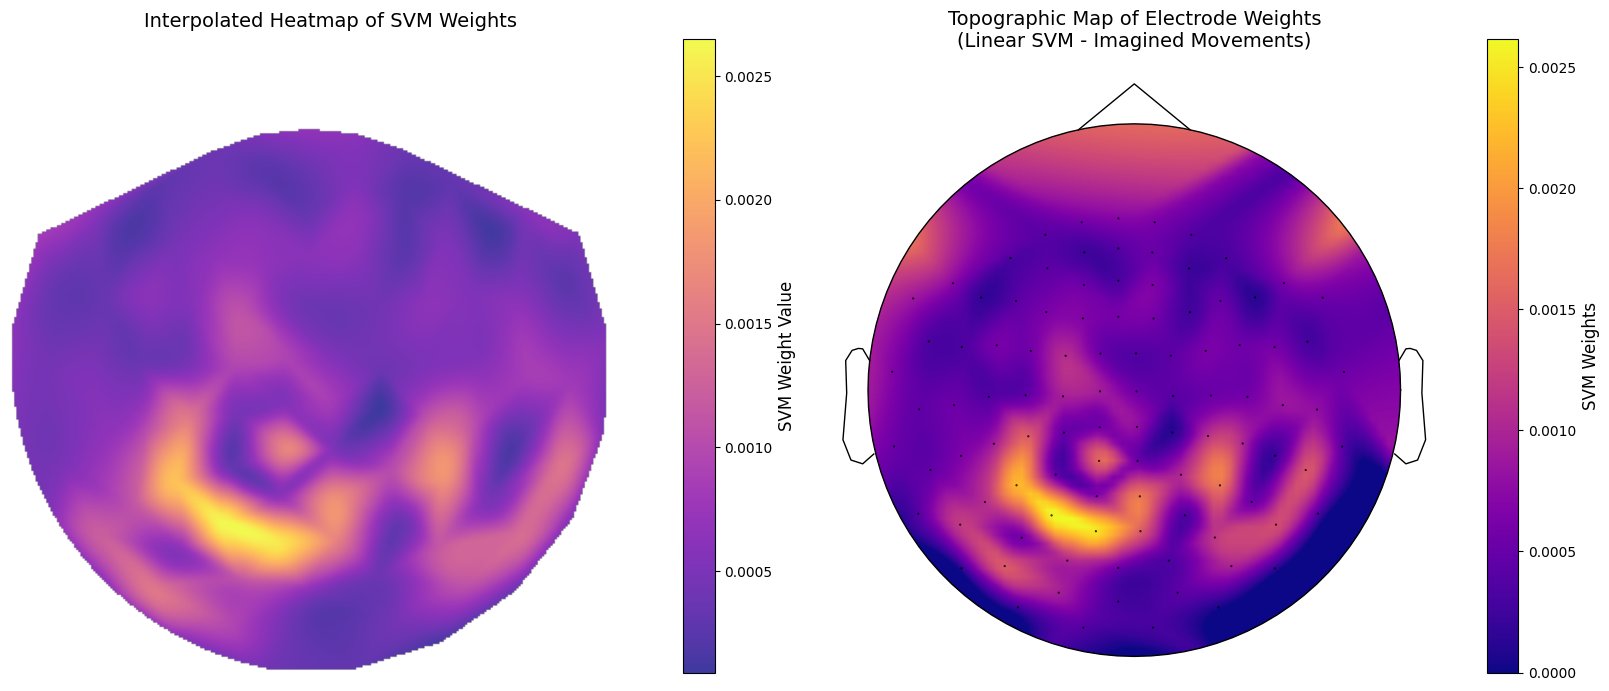

In [19]:
# Create the figure and axes with constrained layout for better spacing
fig, ax = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

# Plot the topomap for electrode weights
ax[1].set_title("Topographic Map of Electrode Weights\n(Linear SVM - Imagined Movements)", fontsize=14)
im, _ = mne.viz.plot_topomap(
    W_mag,
    electrode_coords_scaled,
    axes=ax[1],
    show=False,  # Disable immediate display to add the colorbar
    cmap='plasma',
    names=None,
    outlines='head',  # Include head outline
    contours=0,  # No contour lines
    sphere=(0, 0, 0, 1.1),  # Define the sphere for the head
    extrapolate='box',  # Extrapolate to the head outline
)

# Add the colorbar for the topomap
cbar = fig.colorbar(im, ax=ax[1], orientation='vertical', shrink=0.8, pad=0.05)
cbar.set_label("SVM Weights", fontsize=12)

# Plot the interpolated data as a heatmap
im = ax[0].imshow(
    grid_z.T, extent=(-1, 1, -1, 1), origin='lower', cmap='plasma', alpha=0.8
)
ax[0].set_title("Interpolated Heatmap of SVM Weights", fontsize=14)

# Add a colorbar for the heatmap
cbar = fig.colorbar(im, ax=ax[0], orientation='vertical', shrink=0.8, pad=0.05)
cbar.set_label("SVM Weight Value", fontsize=12)

# Turn off the axis for the heatmap for a cleaner look
ax[0].axis('off')

plt.savefig("../figures/linearSVM/topomap_imagined_movements_interpolated_complete.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

#### Vector position on Topographic Map

In [20]:
data_per_electrode = (W_x+W_y)/2

In [21]:
grid_x, grid_y = np.mgrid[-1:1:300j, -1:1:300j]
grid_z = griddata(electrode_coords, data_per_electrode, (grid_x, grid_y), method='cubic')

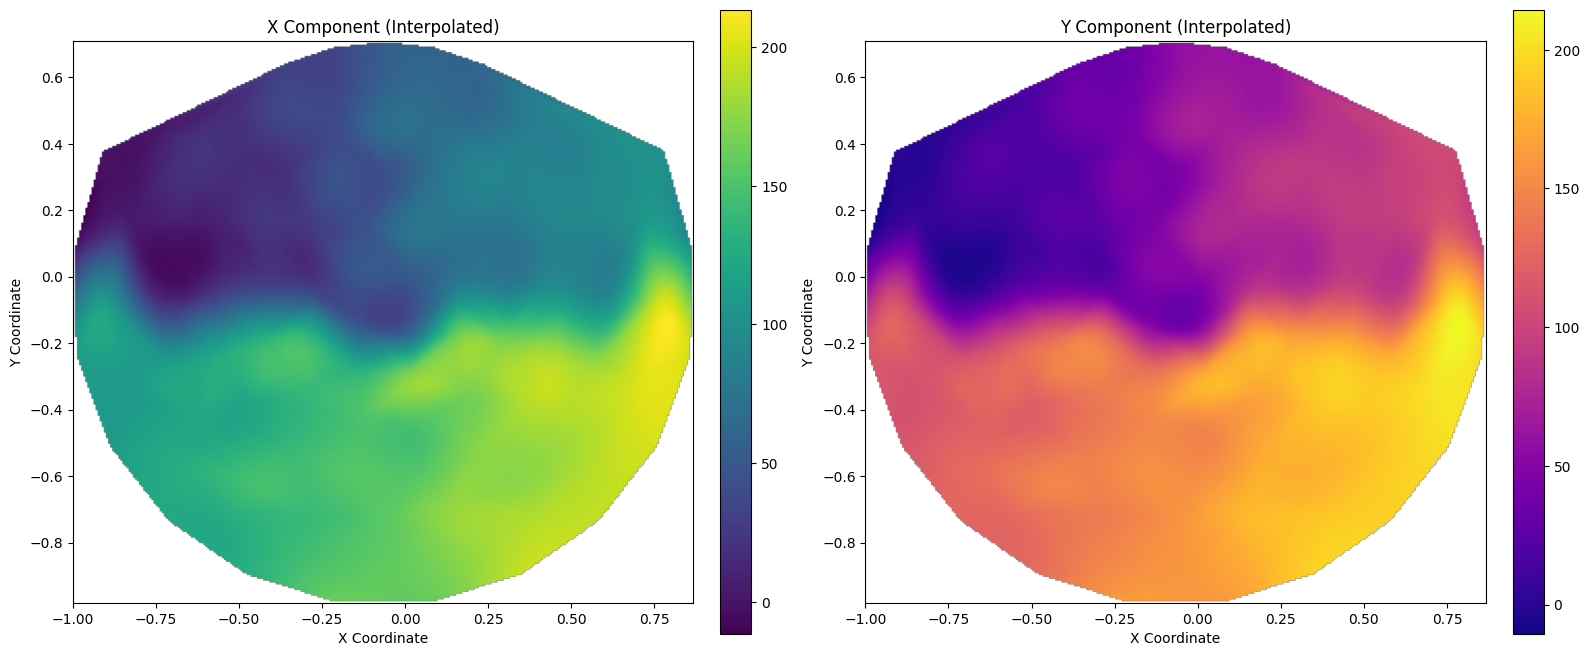

In [22]:
x_coords = electrode_coords_scaled[:, 0]
y_coords = electrode_coords_scaled[:, 1]

# Create indices for the 204 vectors (102 electrodes × 2 components)
vector_indices = np.arange(204)

# Separate the X and Y components of the weights
weights_x = vector_indices[::2]  # X components
weights_y = vector_indices[1::2]  # Y components

# Create a grid for interpolation
grid_x, grid_y = np.mgrid[
    x_coords.min():x_coords.max():300j, y_coords.min():y_coords.max():300j
]

# Interpolate the X and Y components onto the grid
grid_weights_x = griddata((x_coords, y_coords), weights_x, (grid_x, grid_y), method='cubic')
grid_weights_y = griddata((x_coords, y_coords), weights_y, (grid_x, grid_y), method='cubic')

# Plot the interpolated X and Y components
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot X-component meshgrid
im_x = axes[0].imshow(
    grid_weights_x.T, extent=(x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()),
    origin='lower', cmap='viridis'
)
axes[0].set_title('X Component (Interpolated)')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')
fig.colorbar(im_x, ax=axes[0], fraction=0.046, pad=0.04)

# Plot Y-component meshgrid
im_y = axes[1].imshow(
    grid_weights_y.T, extent=(x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()),
    origin='lower', cmap='plasma'
)
axes[1].set_title('Y Component (Interpolated)')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')
fig.colorbar(im_y, ax=axes[1], fraction=0.046, pad=0.04)

# Customize the layout
plt.tight_layout()
plt.grid(False)
plt.savefig("../figures/linearSVM/interpolated_X_Y_components.png", dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Prepare the data for MNE
# Combine x_coords and y_coords into a single array of electrode positions
pos = np.column_stack((x_coords, y_coords))

In [24]:
# Create the data for the X and Y components
weights_x = vector_indices[::2]  # X components
weights_y = vector_indices[1::2]  # Y components

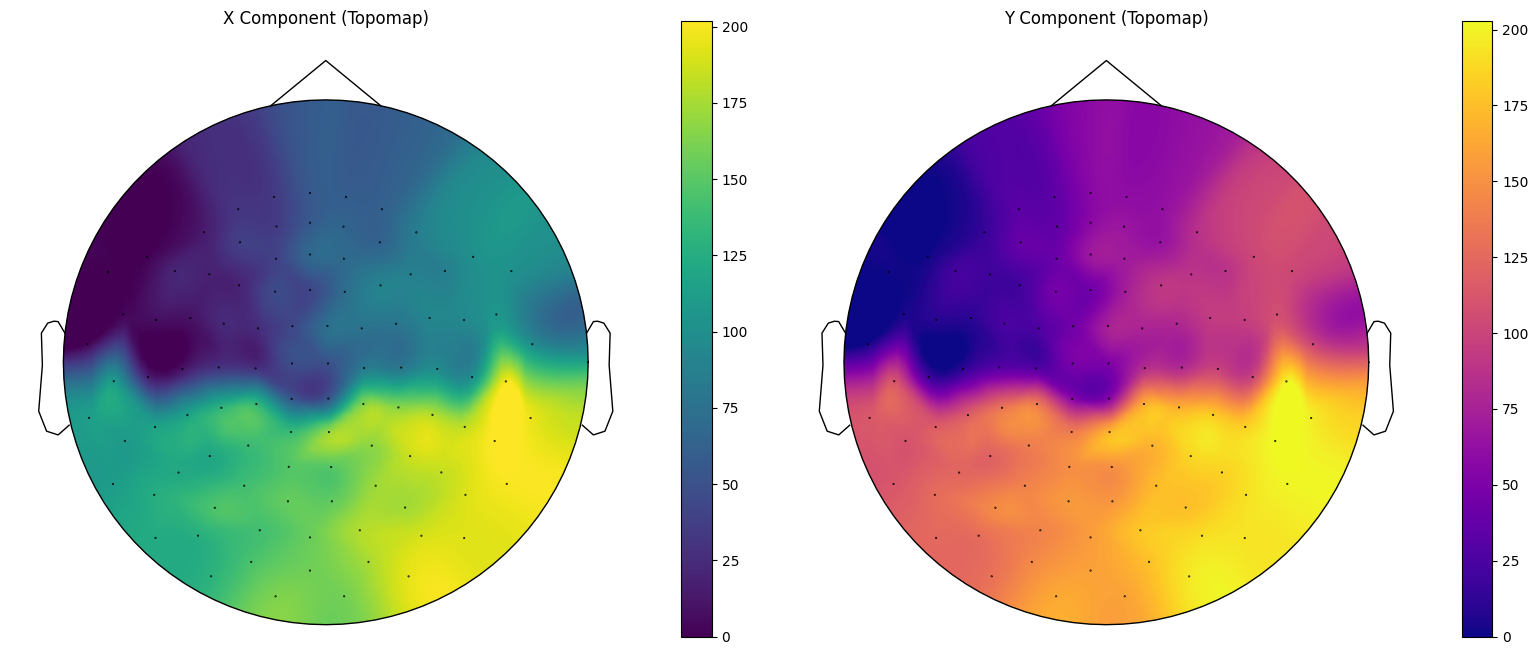

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
# Plot X-component topomap
adjusted_sphere = (0, 0, 0, 1.1)

# Plot X-component topomap
im1, _ = mne.viz.plot_topomap(
    weights_x, pos, axes=axes[0], cmap='viridis', show=False, contours=0,
    outlines='head',  # Include head outline
    sphere=adjusted_sphere,  # Adjust the sphere to align the head with the data
    extrapolate='head',  # Extrapolate to the head outline
)
cbar1 = fig.colorbar(im1, ax=axes[0], orientation='vertical', shrink=0.8, pad=0.05)
axes[0].set_title('X Component (Topomap)')

# Plot Y-component topomap
im2, _ = mne.viz.plot_topomap(
    weights_y, pos, axes=axes[1], cmap='plasma', show=False, contours=0,
    outlines='head',  # Include head outline
    sphere=adjusted_sphere,  # Adjust the sphere to align the head with the data
    extrapolate='head',  # Extrapolate to the head outline
)
cbar2 = fig.colorbar(im2, ax=axes[1], orientation='vertical', shrink=0.8, pad=0.05)
axes[1].set_title('Y Component (Topomap)')

# Customize the layout
plt.tight_layout()
plt.savefig("../figures/linearSVM/X_Y_components_topomap.png", dpi=300, bbox_inches='tight')
plt.show()

## Real Movements dataset

In [26]:
df_real_class_1 = pd.read_csv('../data/feaSubEOvert_1.csv', header=None)
df_real_class_2 = pd.read_csv('../data/feaSubEOvert_2.csv', header=None)

In [27]:
df1_real = df_real_class_1.T
df2_real = df_real_class_2.T

In [28]:
X = pd.concat([df1_real, df2_real], axis=0)
y = np.array([0]*df1_real.shape[0] + [1]*df2_real.shape[0])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Linear SVM Classifier Training

In [30]:
model = SVC(kernel='linear', C=1., probability=True)  # C is the regularization parameter
model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [50]:
y_pred = clf.predict(X_test)
y_score = clf.decision_function(X_test)  # this is your decision statistic
accuracy = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_score)

In [51]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9166666666666666
Accuracy: 0.9167
ROC AUC: 0.9756

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92        41
           1       0.86      0.97      0.91        31

    accuracy                           0.92        72
   macro avg       0.92      0.92      0.92        72
weighted avg       0.92      0.92      0.92        72



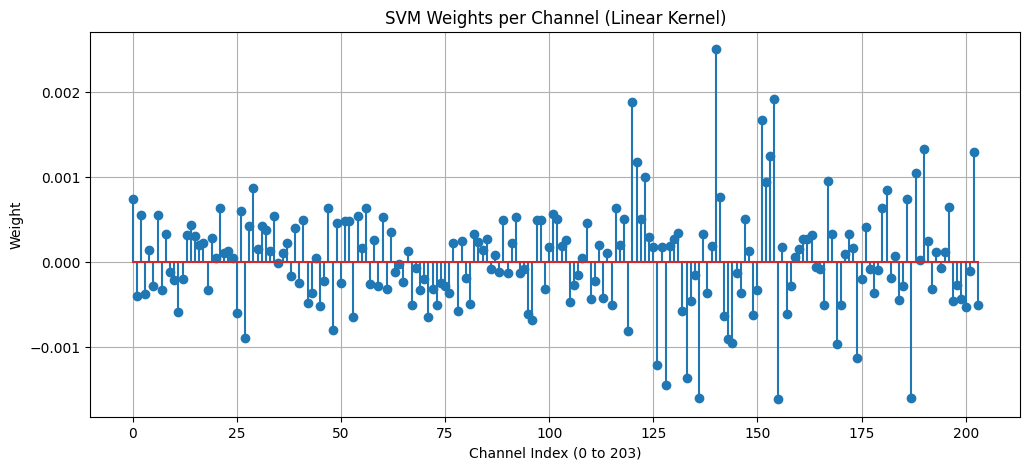

In [34]:
weights = clf.coef_.flatten()  # shape: (204,)
plt.figure(figsize=(12, 5))
plt.stem(weights)
plt.title("SVM Weights per Channel (Linear Kernel)")
plt.xlabel("Channel Index (0 to 203)")
plt.ylabel("Weight")
plt.grid(True)
plt.savefig("../figures/linearSVM/linearSVM_weights_per_channel_real.png", dpi=300, bbox_inches='tight')
plt.show()

In [35]:
# 204 = 102 electrodes × 2 channels (Ex, Ey)
W = clf.coef_.flatten()
W_x = W[::2]  # x-gradient
W_y = W[1::2]  # y-gradient

# Combine into a single scalar per electrode
W_mag = np.sqrt(W_x**2 + W_y**2)  # shape: (102,)

In [36]:
electrode_names = [f"e{i}" for i in range(1, 103)]  # fake names for 102 electrodes
sfreq = 100  # arbitrary sampling rate (no information given)
info = mne.create_info(ch_names=electrode_names, sfreq=sfreq, ch_types='eeg')

In [37]:
electrode_coords_3d = np.hstack([electrode_coords_scaled, np.zeros((electrode_coords.shape[0], 1))])
pos_dict = dict(zip(electrode_names, electrode_coords_3d))
montage = mne.channels.make_dig_montage(ch_pos=pos_dict, coord_frame='head')
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: e1, e2, e3, e4, e5, e6, e7, e8, e9, e10, e11, e12, e13, e14, ...
 chs: 102 EEG
 custom_ref_applied: False
 dig: 105 items (3 Cardinal, 102 EEG)
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 102
 projs: []
 sfreq: 100.0 Hz
>

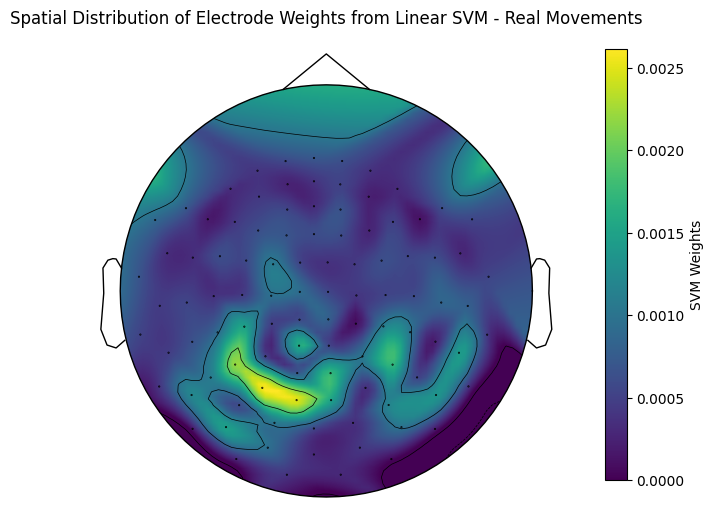

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title("Spatial Distribution of Electrode Weights from Linear SVM - Real Movements")

# Plot the topomap with a colorbar
im, _ = mne.viz.plot_topomap(
    W_mag,
    electrode_coords_scaled,
    axes=ax,
    show=False,  # Disable immediate display to add the colorbar
    cmap='viridis',
    names=None,
    outlines='head',  # Include head outline
    sphere=(0, 0, 0, 1.1),  # Define the sphere for the head
    extrapolate='box',  # Extrapolate to the head outline
    mask_params=dict(radius=0.1),  # Mask parameters for the head
)

# Add the colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label("SVM Weights")
plt.savefig("../figures/linearSVM/topomap_real_movements_extrapolated_linearSVM.png", dpi=300, bbox_inches='tight')
plt.show()

In [39]:
# Interpolate the data onto a grid
grid_x, grid_y = np.mgrid[-1:1:300j, -1:1:300j]  # Create a grid for interpolation
grid_z = griddata(electrode_coords_scaled, W_mag, (grid_x, grid_y), method='cubic')

mask = np.sqrt(grid_x**2 + grid_y**2) <= 1  # Mask for points inside the head circle
grid_z[~mask] = np.nan  # Set values outside the head to NaN

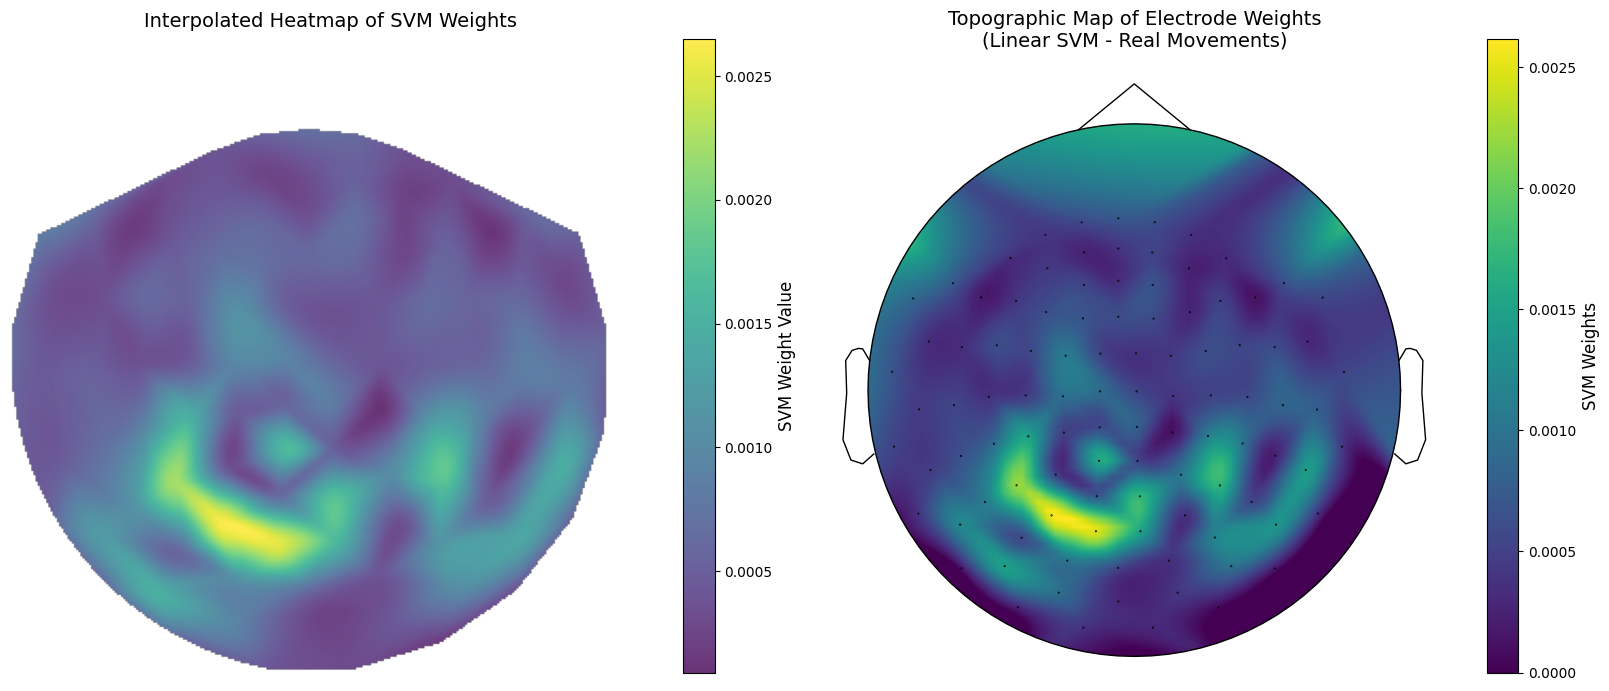

In [40]:
# Create the figure and axes with constrained layout for better spacing
fig, ax = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

# Plot the topomap for electrode weights
ax[1].set_title("Topographic Map of Electrode Weights\n(Linear SVM - Real Movements)", fontsize=14)
im, _ = mne.viz.plot_topomap(
    W_mag,
    electrode_coords_scaled,
    axes=ax[1],
    show=False,  # Disable immediate display to add the colorbar
    cmap='viridis',
    names=None,
    outlines='head',  # Include head outline
    contours=0,  # No contour lines
    sphere=(0, 0, 0, 1.1),  # Define the sphere for the head
    extrapolate='box',  # Extrapolate to the head outline
)

# Add the colorbar for the topomap
cbar = fig.colorbar(im, ax=ax[1], orientation='vertical', shrink=0.8, pad=0.05)
cbar.set_label("SVM Weights", fontsize=12)

# Plot the interpolated data as a heatmap
im = ax[0].imshow(
    grid_z.T, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis', alpha=0.8
)
ax[0].set_title("Interpolated Heatmap of SVM Weights", fontsize=14)

# Add a colorbar for the heatmap
cbar = fig.colorbar(im, ax=ax[0], orientation='vertical', shrink=0.8, pad=0.05)
cbar.set_label("SVM Weight Value", fontsize=12)

# Turn off the axis for the heatmap for a cleaner look
ax[0].axis('off')

plt.savefig("../figures/linearSVM/topomap_real_movements_interpolated_complete_linearSVM.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## Decision statistic from the SVM

In [41]:
Xin = pd.concat([df1_im, df2_im], axis=0)
yin = np.array([0]*df1_im.shape[0] + [1]*df2_im.shape[0])

Xreal = pd.concat([df1_real, df2_real], axis=0)
yreal = np.array([0]*df1_real.shape[0] + [1]*df2_real.shape[0])

In [42]:
Xin_train, Xin_test, yin_train, yin_test = train_test_split(Xin, yin, test_size=0.25)
Xreal_train, Xreal_test, yreal_train, yreal_test = train_test_split(Xreal, yreal, test_size=0.25)

In [43]:
model_imag = SVC(kernel='linear', C=1., probability=True)  # C is the regularization parameter
model_real = SVC(kernel='linear', C=1., probability=True)  # C is the regularization parameter
model_imag.fit(Xin_train, yin_train)
model_real.fit(Xreal_train, yreal_train)

SVC(kernel='linear', probability=True)

In [44]:
y_score_imag = model_imag.decision_function(Xin_test)  # this is your decision statistic
y_score_real = model_real.decision_function(Xreal_test)  # this is your decision statistic

In [45]:
accuracy_imag = accuracy_score(yin_test, model_imag.predict(Xin_test))
accuracy_real = accuracy_score(yreal_test, model_real.predict(Xreal_test))
print(f"Accuracy Imagined: {accuracy_imag:.4f}")
print(f"Accuracy Real: {accuracy_real:.4f}")

Accuracy Imagined: 0.8500
Accuracy Real: 0.9167


In [46]:
fprin, tprin, _ = roc_curve(yin_test, y_score_imag)
fpr, tpr, _ = roc_curve(yreal_test, y_score_real)
roc_auc_score_imag = auc(fprin, tprin)
roc_auc_score_real = auc(fpr, tpr)
print(f"ROC AUC Imagined: {roc_auc_score_imag:.4f}")
print(f"ROC AUC Real: {roc_auc_score_real:.4f}")

ROC AUC Imagined: 0.9208
ROC AUC Real: 0.9856


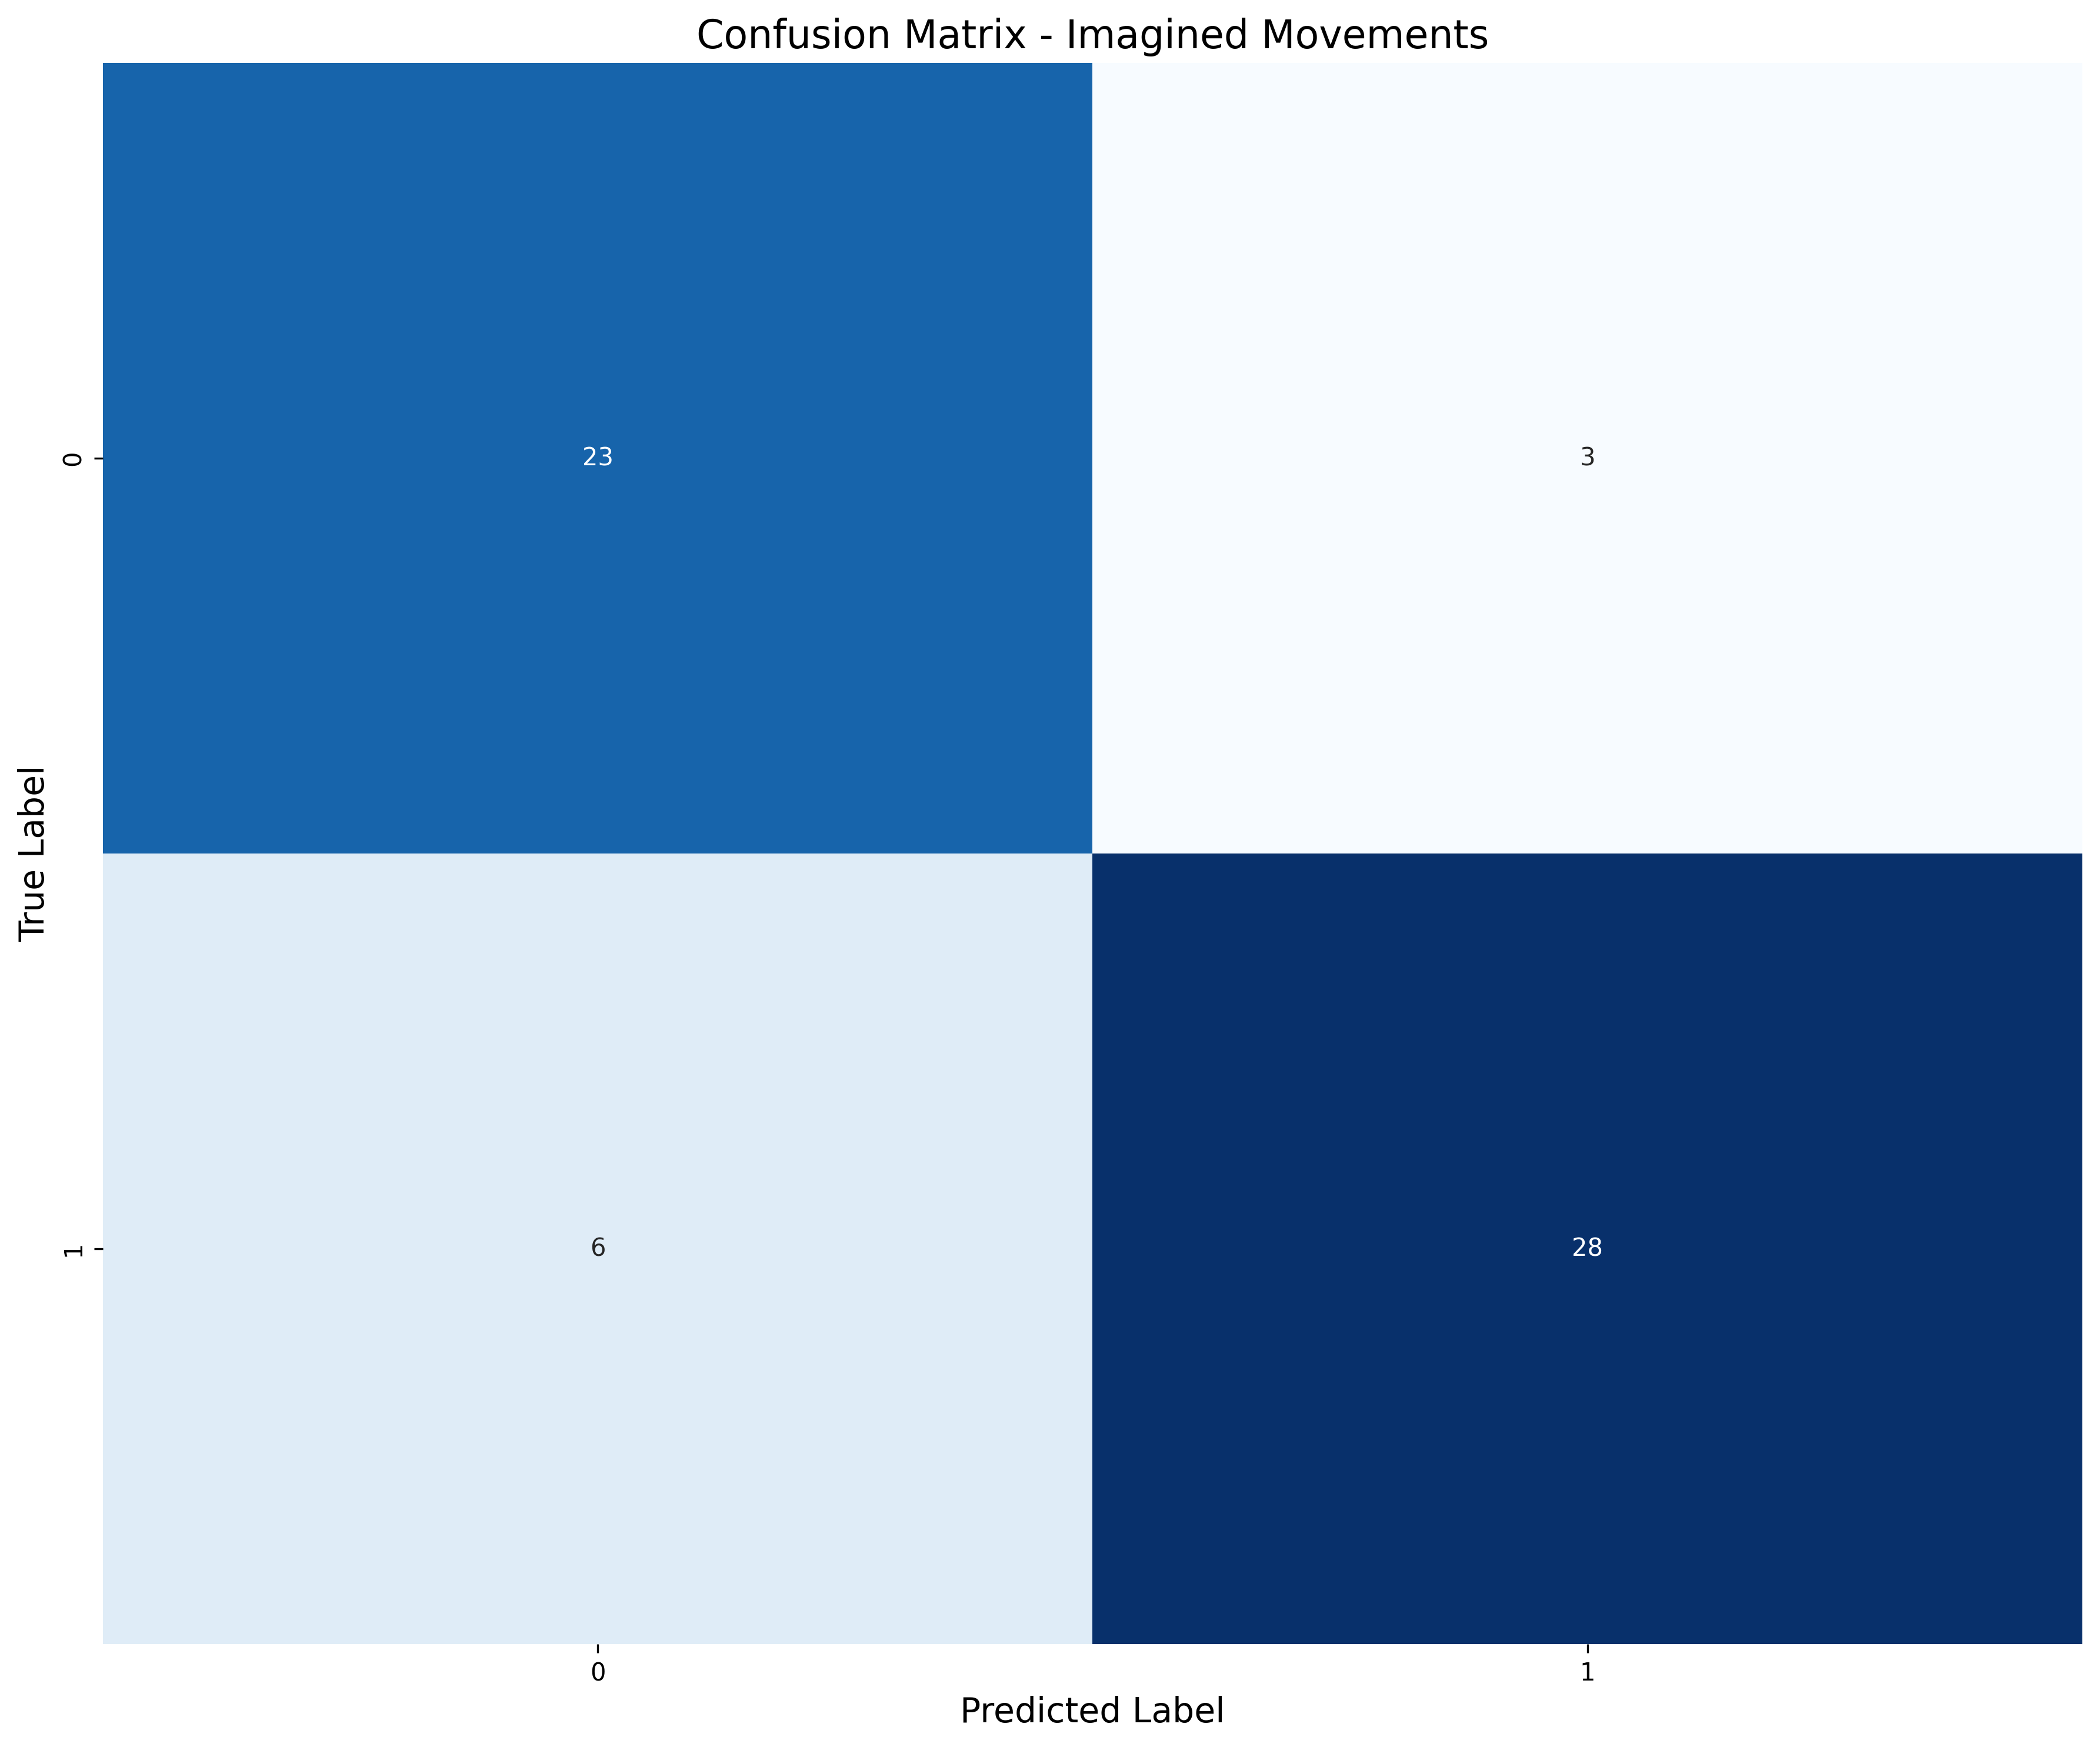

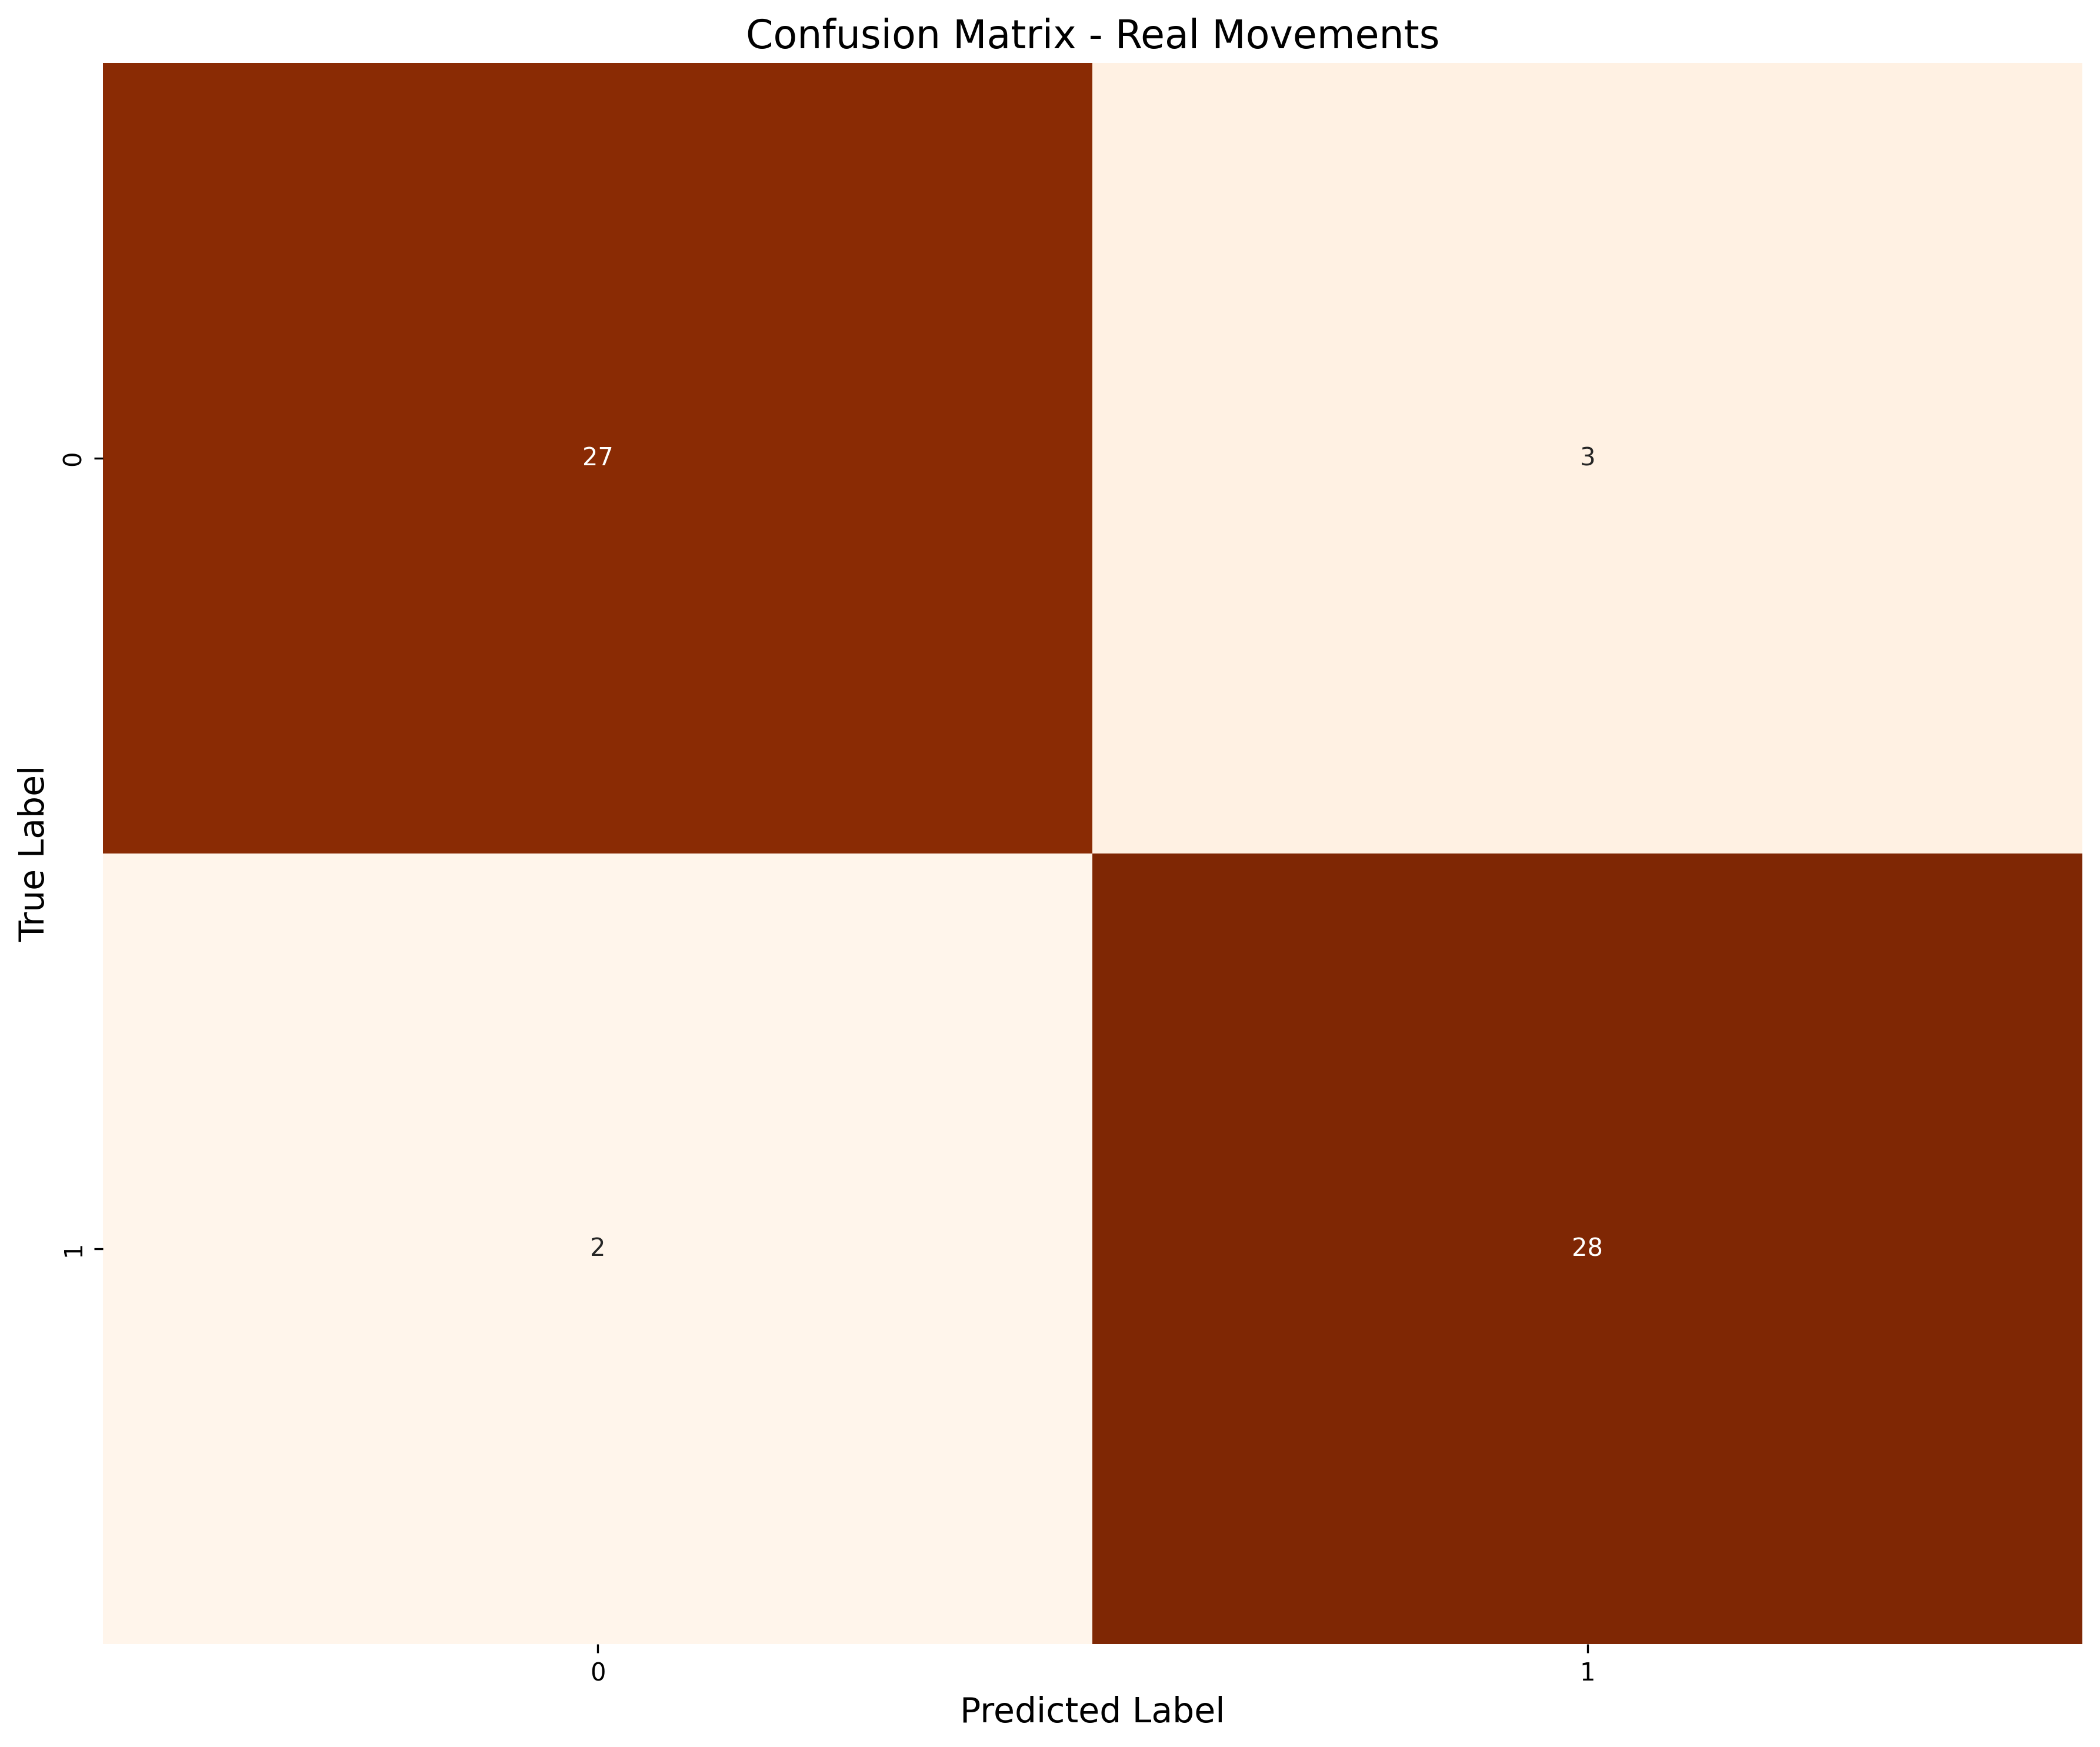

In [47]:
# Imagined Movements Confusion Matrix
cm_imag = confusion_matrix(yin_test, model_imag.predict(Xin_test))
fig1, ax1 = plt.subplots(figsize=(12,10), dpi=300)
sns.heatmap(cm_imag, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=model_imag.classes_, yticklabels=model_imag.classes_, ax=ax1)
ax1.set_xlabel('Predicted Label', fontsize=14)
ax1.set_ylabel('True Label', fontsize=14)
ax1.set_title('Confusion Matrix - Imagined Movements', fontsize=16)
plt.tight_layout()
plt.savefig("../figures/linearSVM/confusion_matrix_imagined_movements_linearSVM.png", dpi=300)
plt.show()

# Real Movements Confusion Matrix
cm_real = confusion_matrix(yreal_test, model_real.predict(Xreal_test))
fig2, ax2 = plt.subplots(figsize=(12,10), dpi=300)
sns.heatmap(cm_real, annot=True, fmt='d', cmap='Oranges', cbar=False, 
            xticklabels=model_real.classes_, yticklabels=model_real.classes_, ax=ax2)
ax2.set_xlabel('Predicted Label', fontsize=14)
ax2.set_ylabel('True Label', fontsize=14)
ax2.set_title('Confusion Matrix - Real Movements', fontsize=16)
plt.tight_layout()
plt.savefig("../figures/linearSVM/confusion_matrix_real_movements_linearSVM.png", dpi=300)
plt.show()

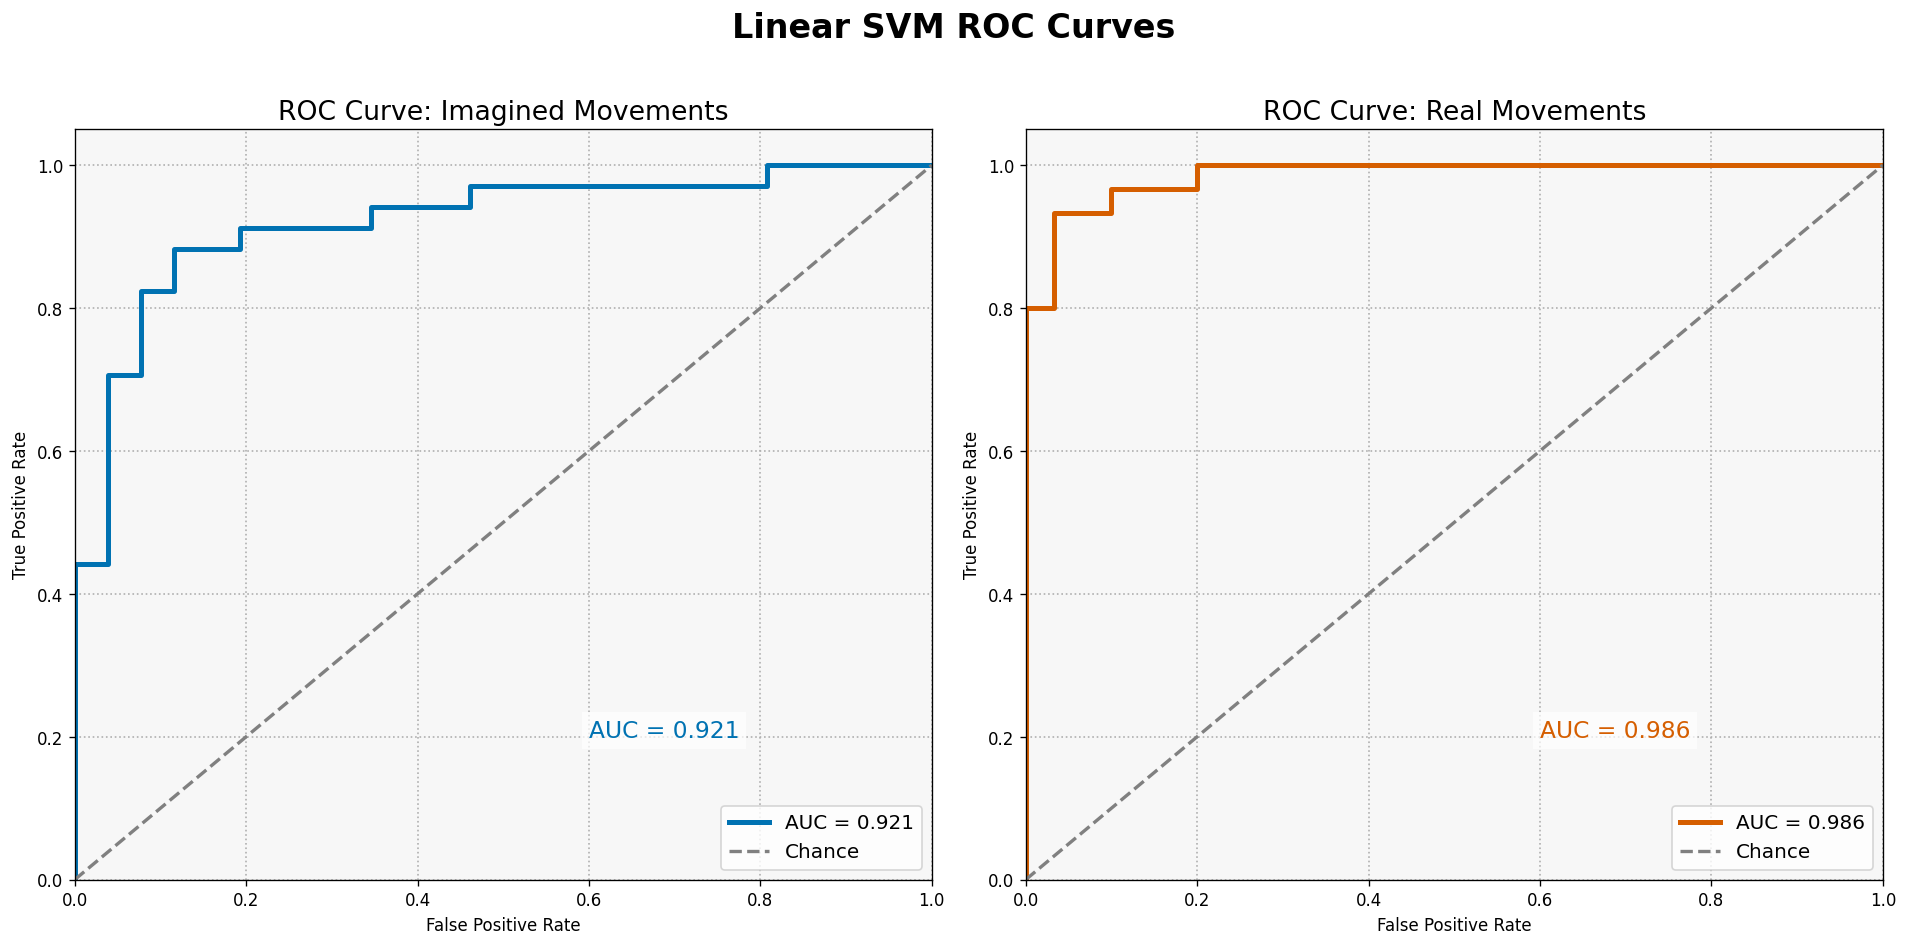

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), dpi=120)
colors = ['#0072B2', '#D55E00']

# Imagined Movements ROC
ax[0].plot(fprin, tprin, color=colors[0], lw=3, label=f'AUC = {roc_auc_score_imag:.3f}')
ax[0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Chance')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_title('ROC Curve: Imagined Movements', fontsize=16)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc='lower right', fontsize=12)
ax[0].grid(True, linestyle=':', linewidth=1)
ax[0].set_facecolor('#f7f7f7')

# Annotate AUC
ax[0].text(0.6, 0.2, f'AUC = {roc_auc_score_imag:.3f}', fontsize=14, color=colors[0], bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Real Movements ROC
ax[1].plot(fpr, tpr, color=colors[1], lw=3, label=f'AUC = {roc_auc_score_real:.3f}')
ax[1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Chance')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_title('ROC Curve: Real Movements', fontsize=16)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc='lower right', fontsize=12)
ax[1].grid(True, linestyle=':', linewidth=1)
ax[1].set_facecolor('#f7f7f7')

# Annotate AUC
ax[1].text(0.6, 0.2, f'AUC = {roc_auc_score_real:.3f}', fontsize=14, color=colors[1], bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.suptitle("Linear SVM ROC Curves", fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("../figures/linearSVM/roc_curves_linear_SVM.png", dpi=300, bbox_inches='tight')
plt.show()

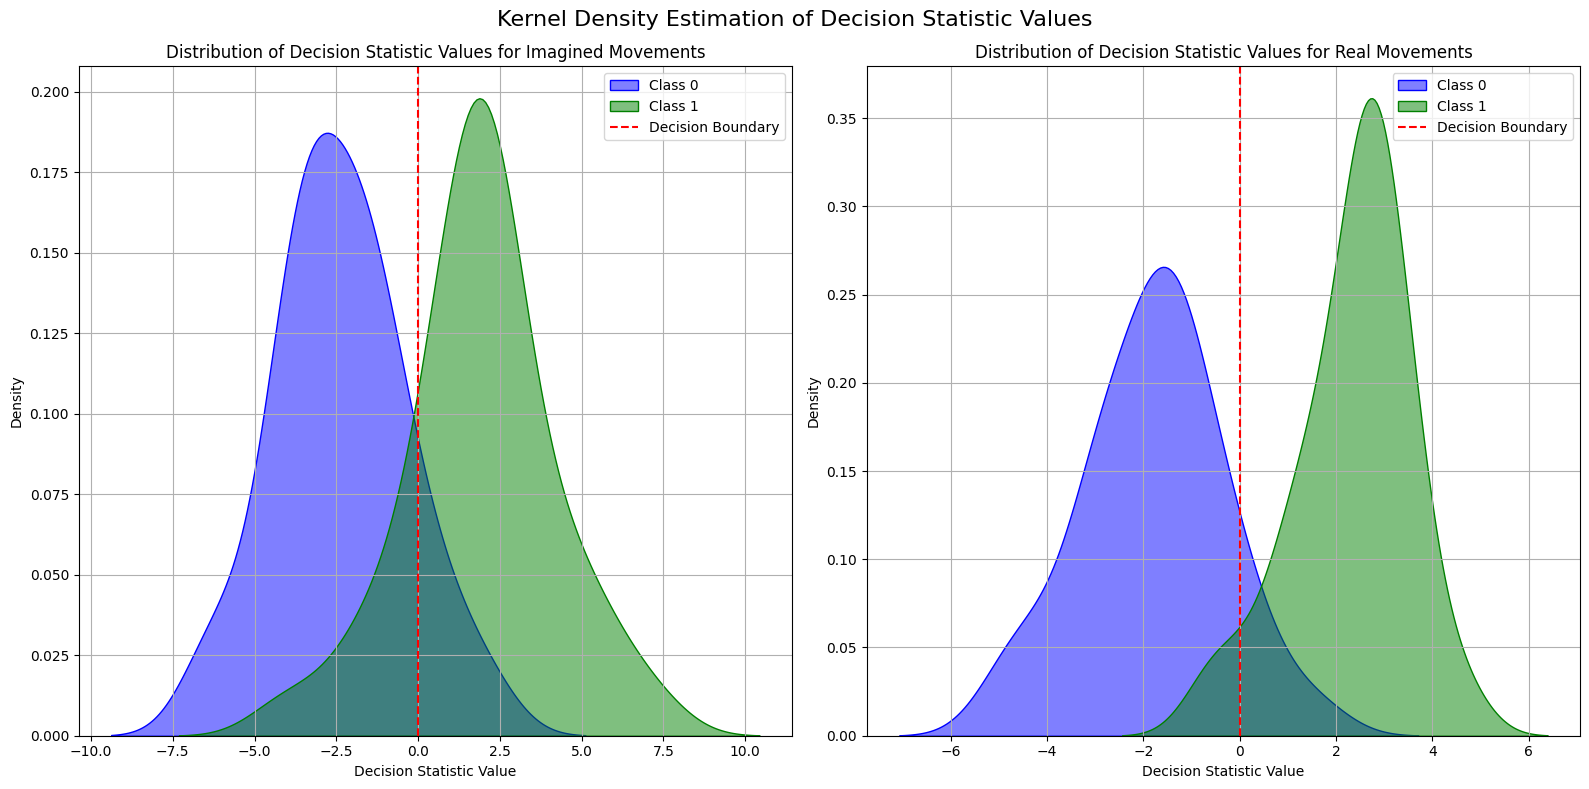

In [49]:
# Kernel density estimation plot of Decision Statistic Values
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Kernel Density Estimation of Decision Statistic Values', fontsize=16)

# For Imagined Movements
sns.kdeplot(y_score_imag[yin_test == 0], ax=ax[0], fill=True, alpha=0.5, label='Class 0', color='blue')
sns.kdeplot(y_score_imag[yin_test == 1], ax=ax[0], fill=True, alpha=0.5, label='Class 1', color='green')
ax[0].axvline(x=0, color='red', linestyle='--', label='Decision Boundary')
ax[0].set_xlabel('Decision Statistic Value')
ax[0].set_ylabel('Density')
ax[0].set_title('Distribution of Decision Statistic Values for Imagined Movements')
ax[0].legend()
ax[0].grid(True)

# For Real Movements
sns.kdeplot(y_score_real[yreal_test == 0], ax=ax[1], fill=True, alpha=0.5, label='Class 0', color='blue')
sns.kdeplot(y_score_real[yreal_test == 1], ax=ax[1], fill=True, alpha=0.5, label='Class 1', color='green')
ax[1].axvline(x=0, color='red', linestyle='--', label='Decision Boundary')
ax[1].set_xlabel('Decision Statistic Value')
ax[1].set_ylabel('Density')
ax[1].set_title('Distribution of Decision Statistic Values for Real Movements')
ax[1].legend()
ax[1].grid(True)

plt.savefig("../figures/linearSVM/decision_statistic_distributions_linear_SVM.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Scenarios implementation on Dataset

### 